In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
def combine_data(folder_path):
    data_frames = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep='\t', names=["ID", "Text", "Emotion", "Intensity"])
            data_frames.append(df)

    combined_data = pd.concat(data_frames, ignore_index=True)
    return combined_data

In [3]:
def preprocess_text(text):

    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if '@' not in word)  # Remove mentions
    text = ' '.join(word for word in text.split() if 'http' not in word)  # Remove URLs

    return text

In [4]:
# Combining the train data and dev data for training.
training_data = combine_data('train')
dev_data = combine_data('development/with_intensity')

In [5]:
train_data = pd.concat([training_data, dev_data], ignore_index=True)

In [6]:
train_data.shape

(3960, 4)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         3960 non-null   int64  
 1   Text       3960 non-null   object 
 2   Emotion    3960 non-null   object 
 3   Intensity  3960 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 123.9+ KB


# Train the model using training data and dev data.

In [8]:
train_data['Text'].apply(preprocess_text)

0       how the fu*k! who the heck! moved my fridge!.....
1       so my indian uber driver just called someone t...
2       i asked for my parcel to be delivered to a pic...
3       so ef whichever butt wipe pulled the fire alar...
4       don't join they put the phone down on you, tal...
                              ...                        
3955    common app just randomly logged me out as i wa...
3956    i'd rather laugh with the rarest genius, in be...
3957    if you #invest in my new #film i will stop ask...
3958    just watched django unchained, other people ma...
3959    depressing how despicable trump, with no polic...
Name: Text, Length: 3960, dtype: object

In [9]:
train_data.head()

,ID,Text,Emotion,Intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [10]:
train_data['Text'].apply(lambda x: len(x)).max()

160

In [11]:
train_data = pd.get_dummies(train_data, columns=['Emotion'], prefix = '', prefix_sep = '')

In [12]:
train_data.head()

,ID,Text,Intensity,anger,fear,joy,sadness
0,10000,How the fu*k! Who the heck! moved my fridge!.....,0.938,1,0,0,0
1,10001,So my Indian Uber driver just called someone t...,0.896,1,0,0,0
2,10002,@DPD_UK I asked for my parcel to be delivered ...,0.896,1,0,0,0
3,10003,so ef whichever butt wipe pulled the fire alar...,0.896,1,0,0,0
4,10004,Don't join @BTCare they put the phone down on ...,0.896,1,0,0,0


In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data[['Text', 'anger', 'fear', 'joy', 'sadness']],
    train_data['Intensity'],
    test_size=0.2,
    random_state=42
)

In [14]:
# Loading DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [15]:
# Tokenizing the Text column.
max_length = 160
tokenized_text_train = tokenizer(X_train['Text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="tf")
tokenized_text_val = tokenizer(X_val['Text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="tf")

In [16]:

# Converting 'input_ids' and 'attention_mask' to numpy arrays.
X_train_ids = tokenized_text_train['input_ids'].numpy()
X_train_mask = tokenized_text_train['attention_mask'].numpy()

In [17]:
X_val_ids = tokenized_text_val['input_ids'].numpy()
X_val_mask = tokenized_text_val['attention_mask'].numpy()

In [18]:
# Loading the DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Freeze the DistilBERT layers.
distilbert_model.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [19]:
# Create the model
input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
emotion = Input(shape=(4,), dtype=tf.float32, name='emotion')  # Assuming 4 emotions

In [20]:
emotion

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'emotion')>

In [21]:
# DistilBERT processing
distilbert_output = distilbert_model(input_ids, attention_mask=attention_mask)['last_hidden_state']
distilbert_output = tf.reduce_mean(distilbert_output, axis=1)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [22]:
# Emotion processing
emotion_dense = Dense(64, activation='relu')(emotion)

# Concatenating processed text and emotion features
merged_output = tf.keras.layers.concatenate([distilbert_output, emotion_dense])

In [23]:
# Add additional layers for regression
x = Dense(512, activation='relu')(merged_output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)  # Add another dense layer
x = Dropout(0.2)(x)
output = Dense(1, activation='linear')(x)


In [24]:
model = tf.keras.Model(inputs=[input_ids, attention_mask, emotion], outputs=output)


In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mse'])


In [26]:
# Train the model
epochs = 8
history = model.fit(
    {'input_ids': X_train_ids, 'attention_mask': X_train_mask, 'emotion': X_train[['anger', 'fear', 'joy', 'sadness']]},
    y_train,
    epochs=epochs,
    validation_data=(
        {'input_ids': X_val_ids, 'attention_mask': X_val_mask, 'emotion': X_val[['anger', 'fear', 'joy', 'sadness']]},
        y_val
    )
)

Epoch 1/8
99/99 [==============================] - 116s 1s/step - loss: 0.0571 - mse: 0.0571 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 2/8
99/99 [==============================] - 116s 1s/step - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 3/8
99/99 [==============================] - 119s 1s/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 4/8
99/99 [==============================] - 119s 1s/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 5/8
99/99 [==============================] - 118s 1s/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 6/8
99/99 [==============================] - 119s 1s/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 7/8
99/99 [==============================] - 120s 1s/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 8/8
99/99 [==============================] - 115s 1s/step - loss: 0.0247 - mse: 0.02

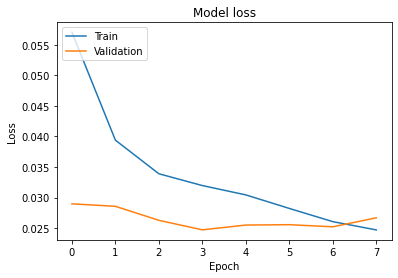

In [27]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# testing the model for test data.


In [28]:
# Testing_data
test_data = combine_data('test/with_intensity')
test_data.shape

(3142, 4)

In [29]:
test_data['Text'].apply(preprocess_text)

0       at the point today where if someone says somet...
1             it's game day!!!! t minus 14:30 #relentless
2       this game has pissed me off more than any othe...
3       i've just found out it's candice and not canda...
4       if he can't come to my mum'a 60th after 25k tw...
                              ...                        
3137            why does candice constantly pout #gbbo 💄😒
3138    #unhappy with #redbus cc, when i talked with t...
3139    no pull him afew weeks ago, sadly theres no ga...
3140    i'm buying art supplies and i'm debating how s...
3141    could you ask your chafford hundred store to t...
Name: Text, Length: 3142, dtype: object

In [30]:
test_data_encoded = pd.get_dummies(test_data, columns=['Emotion'], prefix='', prefix_sep='')

In [31]:
# Tokenize the text column in your testing dataframe
test_tokenized_text = tokenizer(test_data_encoded['Text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="tf")

In [32]:
# Get input_ids and attention_mask
X_test_input_ids = test_tokenized_text['input_ids'].numpy()
X_test_attention_mask = test_tokenized_text['attention_mask'].numpy()

In [33]:
# Assuming you have dummy variables for 'Emotion' in test_data_encoded
test_emotion = test_data_encoded[['anger', 'fear', 'joy', 'sadness']].values

In [34]:
# Make predictions
test_predictions = model.predict({'input_ids': X_test_input_ids, 'attention_mask': X_test_attention_mask, 'emotion': test_emotion})


99/99 [==============================] - 102s 1s/step


In [35]:
# test_predictions' contains the predicted intensity values
# 'test_data' is our test dataframe
test_data['Predicted_Intensity'] = test_predictions

# Display a subset of the actual and predicted values for comparison
print(test_data[['Intensity', 'Predicted_Intensity']].head(6))

   Intensity  Predicted_Intensity
0      0.319             0.357315
1      0.144             0.319397
2      0.898             0.559356
3      0.271             0.330375
4      0.646             0.425333
5      0.583             0.429818


In [36]:
len(test_predictions)

3142

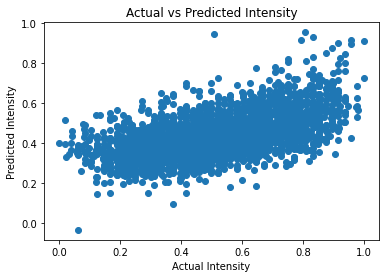

In [37]:
plt.scatter(test_data['Intensity'], test_data['Predicted_Intensity'])
plt.xlabel('Actual Intensity')
plt.ylabel('Predicted Intensity')
plt.title('Actual vs Predicted Intensity')
plt.show()

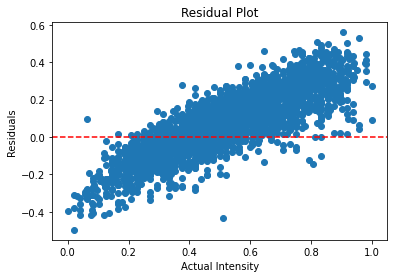

In [38]:
residuals = test_data['Intensity'] - test_data['Predicted_Intensity']
plt.scatter(test_data['Intensity'], residuals)
plt.xlabel('Actual Intensity')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

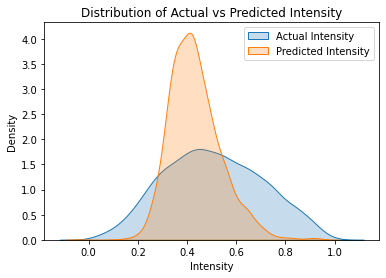

In [39]:
sns.kdeplot(test_data['Intensity'], label='Actual Intensity', shade=True)
sns.kdeplot(test_data['Predicted_Intensity'], label='Predicted Intensity', shade=True)
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.title('Distribution of Actual vs Predicted Intensity')
plt.legend()
plt.show()

In [40]:
mse = mean_squared_error(test_data['Intensity'], test_data['Predicted_Intensity'])
mae = mean_absolute_error(test_data['Intensity'], test_data['Predicted_Intensity'])

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.03132891192575326
Mean Absolute Error: 0.14238446757801584


In [41]:
from sklearn.metrics import r2_score

y_true = test_data['Intensity'].values

# Replace 'Predicted_Intensity' with the column name in your DataFrame containing the predicted intensity values
y_pred = test_data['Predicted_Intensity'].values

r2 = r2_score(y_true, y_pred)
print(f'R-squared Score: {r2}')

R-squared Score: 0.20548674277649082
